# USTG

In [1]:
!pip -q install selfies
!pip -q install rdkit

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import pandas as pd
import selfies as sf
import re


## Data Preparation

In [3]:
import pandas as pd

pd.options.mode.chained_assignment = None

SMILESdb = pd.read_csv('sample_db_only_smiles.csv')
print(SMILESdb.shape)
SMILESdb.head()

def encode_smiles(smiles):
    try:
        return sf.encoder(smiles)
    except Exception as e:
        return ''

SMILESdb['smiles'] = SMILESdb['smiles'].apply(encode_smiles)

SMILES = SMILESdb[SMILESdb['smiles'] != '']

SMILES['smiles'].to_csv('sample.txt', index=False)

bag_of_chem = ''.join(['[^]' + smiles for smiles in SMILESdb['smiles']])
print(bag_of_chem[:50])

(29547, 3)
[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][


## Tokenization

In [4]:
from tokenizer import Tokenizer

t = Tokenizer(bag_of_chem)

t.train_bpe(bag_of_chem, 4)

loaded_vocab = t.load()
testy = t.encode('[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][Si][Branch1][C][C][Branch1][C][C][C][Branch1][=Branch2][Si]', loaded_vocab)

print(t.decode(testy, loaded_vocab))

Iteration: 1, most often pair: [C][=C], occurs 197636 times, length of all tokenized data set: 2004504
Iteration: 2, most often pair: [C][C], occurs 181151 times, length of all tokenized data set: 1806868
Iteration: 3, most often pair: [C][=C][C][=C], occurs 86732 times, length of all tokenized data set: 1688682
Iteration: 4, most often pair: [Branch1][C][C], occurs 65978 times, length of all tokenized data set: 1633669
[^][In][Branch2][Ring1][=C][C][Branch1][=Branch2][Si][Branch1][C][C][Branch1][C][C][C][Branch1][=Branch2][Si]


## Architecture

## Training

In [5]:
#conventional training loop

from transformer import *
data = torch.tensor(t.encode(bag_of_chem, loaded_vocab))

train_test_split = 0.9
train_data = data[:int(train_test_split*len(data))]
valid_data = data[int(train_test_split*len(data)):]


#conventional training loop
model = TransformerLanguageModel()
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
best_val_loss = 10

for step in range(MAX_ITERS):

    if step % EVAL_ITERS == 0 or step == MAX_ITERS-1:
        losses = estimate_loss(model, train_data, valid_data)
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train', train_data, valid_data, BATCH_SIZE, CONTEXT_LEN)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=DEVICE)

Step: 0 Training Loss: tensor(6.5622) Validation Loss: tensor(6.5983)
Step: 199 Training Loss: tensor(2.2659) Validation Loss: tensor(2.3227)


In [6]:
new_structure = model.generate(context,max_new_tokens=200)[0].tolist()
new_structure_decode = t.decode(new_structure, loaded_vocab).split('[^]')

for ch in new_structure_decode:
  print(ch)

[Branch1][C][C][Ring2][#Branch2][Branch1][C][C][C][C@@H1][C][C][C][=C][Ring1][=Branch1][O][Ring1][=Branch1][N][C][=C][C][=C][C][=C][Ring1][=Branch1][N][Branch1][C][=C][C][C@H1][Branch1][=C][C][=C][Branch1][C][C][C][=C][Ring1][=Branch1][C][C][C][Branch1][Ring1][=Branch1][C][=Branch1][C][C][C][Branch1][C][C][Branch1][C][C][C][C][C][C][C][C][C][C][C][C][Branch1][C][C][Branch1][C][C][C][C][C].[Li][Branch1][Ring2][O][/C][C][Branch1][Ring2][Ring1][C@H1][N][C][=C][Ring1][N][Ring2][O][FH0][N][Ring2][C][=Branch1][C][=C][Branch1][C][C][C][C][=C][C][N][=Branch1][Branch1][Ring1][=Branch1][Branch1][C][C][C][C][C][Branch1][C][C][C][C][=C][Ring1][#C][C][I][C][=C][Ring2][=Branch1][C][=C][C][=Branch1][C][=C][Ring1][=Branch1][N][Branch2][Ring2][Ring1][=Branch1][N][Branch1][S][Ring2][Ring2][Branch1][C][=Branch1][Ring2][Ring2][Branch1][C][=Branch1][Branch1][C][C][C][C][C][C][C][Cl][Branch1][C][C][C][C][Branch1][C][C][C][C][C][C][C][Branch1][C][C][Ring2][#Branch1][C][C][C][C][Branch2][Ring2][Ring1][C][C][C

## Results

In [7]:
output_smi = []
for el in new_structure_decode:
  output_smi.append(sf.decoder(el))
output_smi

['C1=CCCC2[C@@H1]3CCC=C2O3.[Li](O/CC)C=C1']

[13:58:55] unsupported number of radical electrons 5


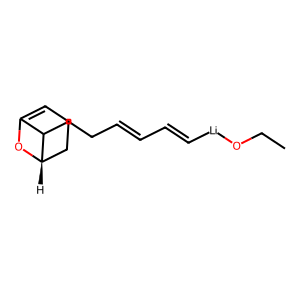

In [9]:
from rdkit import Chem
from rdkit.Chem import Draw

import numpy as np

m = Chem.MolFromSmiles(output_smi[-1])
img = Draw.MolToImage(m)
img